In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim

In [2]:
from string import printable
import re
import os

### Parse and Load data
The raw data contains some non ASCII characters, so we remove these characters, parse the data, and load all the files into a single pandas dataframe keeping only the "Question" attribute

In [3]:
root = "data"
raw_data_path = os.path.join(root, "raw_data")
parsed_data_path = os.path.join(root, "parsed_data") 
processed_data_path = os.path.join(root, "processed_data")   

In [4]:
for txt_file in os.listdir(raw_data_path):
    raw_file_path = os.path.join(raw_data_path, txt_file)
    parsed_file_path = os.path.join(parsed_data_path, txt_file)
    with open(raw_file_path, "r", encoding="utf-8") as f:
        parsed_file = "".join([char for char in f.read() if char in printable])
    with open(parsed_file_path, "w") as f:
        f.write(parsed_file)

#### Show dataset sample

In [5]:
pd.read_table("data/parsed_data/S08_question_answer_pairs.txt").head()

,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,S08_set3_a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,S08_set3_a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,S08_set3_a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,S08_set3_a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,S08_set3_a4


In [6]:
questions_all = pd.concat([pd.read_table(os.path.join(parsed_data_path, file_name))["Question"] \
 for file_name in os.listdir(parsed_data_path)])

#### Basis Preprocessing
Do some basic preprocessing like dropping null values and duplicates

In [7]:
questions_all.dropna(inplace=True)

In [8]:
questions_all = questions_all.unique()

In [9]:
questions_all[10:15]

array(['Did Lincoln start his political career in 1832?',
       'Did Lincoln ever represent Alton & Sangamon Railroad?',
       'Which county was Lincoln born in?',
       'When did Lincoln first serve as President?',
       'Who assassinated Lincoln?'], dtype=object)

In [10]:
len(questions_all)

2454

#### Preprocessing
remove punctuations, multiple white spaces, tabs, newlines, text between brackets, and null questions

In [11]:
def preprocess_text(question):
    question = question.replace("S08_", "")
    question = question.replace("NOTTTT  FOUND", "")
    question = re.sub("([\(\[]).*?([\)\]])", "", question) # remove text between brackets
    question = re.sub("[^\w\s]", "", question) # remove punctuations
    re.sub("\s+", " ", question) # remove multiple white spaces
    re.sub("[\t\n]", "", question) # remove tabs and newline characters
    question = question.lower().strip()
    return question

In [12]:
questions_processed = [preprocess_text(q) for q in questions_all]
questions_processed = [q for q in questions_processed if len(q) != 0] # remove empty strings after preprocessing

#### Remove long questions
Since we want to emulate a search engine, we ought to remove long sentences and paragraphs

In [13]:
q_lengths = [len(q) for q in questions_processed]

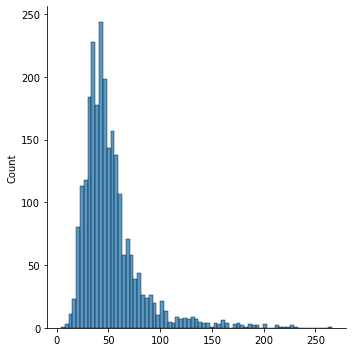

In [14]:
sns.displot(q_lengths)

We can see that most of the questions have lengths between roughly 20 and 80. Let's calculate the optimum length of questions we want to keep - which will be standard deviation distance away from the mean - and discard rest of the long questions

In [15]:
mean = np.mean(q_lengths)
std = np.std(q_lengths)
print(f"mean: {mean}, std: {std}")

mean: 52.3442088091354, std: 29.053359020555256


In [16]:
optimum_length = int(mean + std)
print(f"optimum length: {optimum_length}")

optimum length: 81


In [17]:
questions_short = [q for q in questions_processed if len(q) <= optimum_length]

#### Shuffle Data

In [18]:
import random
random.seed(42)
random.shuffle(questions_short)

In [19]:
questions_short[52:57]

['how old was pascal when he lost his mother',
 'can the palatal nasal occur in word initial position  eg',
 'when did he drop john from his name',
 'why do penguins tobaggan',
 'is nairobi not the capital as well as largest city of kenya']

### Create Dataset and Dataloader
Here we create the vocab, encode questions as char indices, and perform one-hot encoding and padding

In [20]:
class QuestionsDataset(Dataset):
    def __init__(self, questions, vocab, sos_token, eos_token, batch_first=False):
        
        # initialize parameters
        self.sos_idx = 0
        self.eos_idx = 1
        self.int2char = {self.sos_idx: sos_token, self.eos_idx: eos_token} # insert start of sentence and end of sentence tokens
        self.int2char.update({idx: char for idx, char in enumerate(vocab, start=self.eos_idx+1)})
        self.char2int = {char: idx for idx, char in self.int2char.items()}
        self.n_chars = len(self.int2char)
        
        # encode and pad questions
        self.questions_encoded = pad_sequence([self.encode_question(q) for q in questions], \
                                              batch_first=batch_first)
                
    def __len__(self):
        return len(self.questions_encoded)
    
    def __getitem__(self, idx):
        return self.questions_encoded[idx]
        
    def encode_question(self, question):
        '''
        encode question as char indices and perform one-hot encoding
        '''
        question_encoded = [self.sos_idx] # append sos
        for char in question:
            question_encoded.append(self.char2int[char])
        question_encoded.append(self.eos_idx) # append eos
        return F.one_hot(torch.tensor(question_encoded, dtype=torch.long), self.n_chars).float()

In [21]:
vocab = sorted(set("".join(questions_short)))
sos_token = '['
eos_token = ']'
BATCH_FIRST=True
BATCH_SIZE=64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Create train and val set

In [22]:
val_percent = 0.1
n_val = int(val_percent * len(questions_short))
n_train = len(questions_short) - n_val
print(f"n_train: {n_train}, n_val: {n_val}")

n_train: 1977, n_val: 219


In [23]:
questions_train = questions_short[:n_train]
questions_val = questions_short[n_train:]

In [24]:
train_dataset = QuestionsDataset(questions_train, vocab, sos_token, eos_token, batch_first=BATCH_FIRST)
val_dataset = QuestionsDataset(questions_val, vocab, sos_token, eos_token, batch_first=BATCH_FIRST)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [25]:
assert train_dataset.n_chars == val_dataset.n_chars

### Define Model

In [24]:
class charRNN(nn.Module):
    
    def __init__(self, VOCAB_SIZE, HIDDEN_SIZE, N_LAYERS=2, P_DROPOUT=0.5, batch_first=False):
        super().__init__()
        self.HIDDEN_SIZE = HIDDEN_SIZE
        self.N_LAYERS = N_LAYERS
        self.lstm = nn.LSTM(VOCAB_SIZE, HIDDEN_SIZE, batch_first=batch_first, 
                            dropout=P_DROPOUT, num_layers=N_LAYERS)
        self.dropout = nn.Dropout(P_DROPOUT)
        self.fc = nn.Linear(HIDDEN_SIZE, VOCAB_SIZE)
        
    def forward(self, inputs, hidden):
        lstm_out, hidden = self.lstm(inputs, hidden)
        
        # flatten the lstm output
        lstm_out = torch.flatten(lstm_out, start_dim=0, end_dim=1)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, BATCH_SIZE, device):
        hidden = (torch.zeros((self.N_LAYERS, BATCH_SIZE, self.HIDDEN_SIZE), dtype=torch.float32).to(device),
                  torch.zeros((self.N_LAYERS, BATCH_SIZE, self.HIDDEN_SIZE), dtype=torch.float32).to(device))
        return hidden

In [25]:
VOCAB_SIZE=train_dataset.n_chars
HIDDEN_SIZE=512
N_LAYERS=3
P_DROPOUT = 0.4

In [26]:
model = charRNN(VOCAB_SIZE, HIDDEN_SIZE, N_LAYERS, P_DROPOUT, BATCH_FIRST)

### Train the model

In [27]:
model.to(device=device)

charRNN(
  (lstm): LSTM(40, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=40, bias=True)
)

In [28]:
n_epochs = 5
optimizer = optim.Adam(model.parameters())
loss = nn.CrossEntropyLoss()
clip = 5

In [33]:
train_loss_list = []
val_loss_list = []

for epoch in tqdm(range(n_epochs)):  
    
    # training
    # -------------

    n_batches_train = 0
    cummulative_loss_train = 0 
    
    model.train()
    
    # initialize hidden state
    hidden = model.init_hidden(BATCH_SIZE, device)
    
    for data_batch in train_dataloader:
        
        # detach hidden state
        hidden = tuple([h.detach() for h in hidden])
        
        if data_batch.shape[0] != BATCH_SIZE:
            continue
        
        # get data
        labels, targets = data_batch[:, :-1, :].to(device), data_batch[:, 1:, :].to(device)
        # get predictions
        preds, hidden = model(labels, hidden)
        # compute loss
        target_idx = torch.argmax(targets, dim=2).long()
        target_flatten = torch.flatten(target_idx, start_dim=0, end_dim=1)
        train_loss = loss(preds, target_flatten)

        # backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        
        # clip the gradient before updating the weights
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        n_batches_train += 1
        cummulative_loss_train += train_loss.item()
        
    loss_per_epoch_train = cummulative_loss_train / n_batches_train
    train_loss_list.append(loss_per_epoch_train)
    
    # validation
    # ---------------
    
    n_batches_val = 0
    cummulative_loss_val = 0 
    
    model.eval()
    hidden = model.init_hidden(BATCH_SIZE, device)
    
    for data_batch in val_dataloader:
        
        if data_batch.shape[0] != BATCH_SIZE:
            continue

        # get data
        labels, targets = data_batch[:, :-1, :].to(device), data_batch[:, 1:, :].to(device)
        # get predictions
        with torch.no_grad():
            preds, hidden = model(labels, hidden)
            # compute loss
            target_idx = torch.argmax(targets, dim=2).long()
            target_flatten = torch.flatten(target_idx, start_dim=0, end_dim=1)
            val_loss = loss(preds, target_flatten)
            
        n_batches_val += 1
        cummulative_loss_val += val_loss.item()
    
    loss_per_epoch_val = cummulative_loss_val / n_batches_val
    val_loss_list.append(loss_per_epoch_val)
    
    # save the model for every 10 epochs
    if epoch % 10 == 0:
        save_path = f"saved_models/char_rnn_epoch_{epoch}.pt"
        torch.save(model.state_dict(), save_path)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:05<00:00, 49.20s/it]


#### Plot the curves

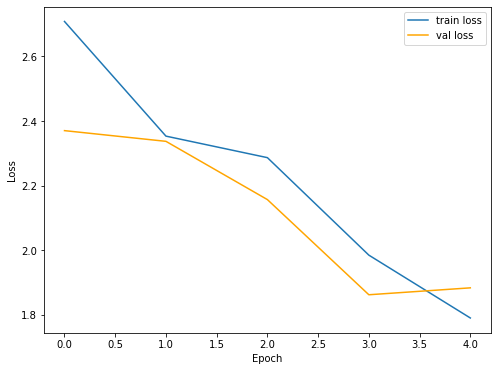

In [34]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.plot(list(range(n_epochs)), train_loss_list, label="train loss")
axes.plot(list(range(n_epochs)), val_loss_list, color='orange', label="val loss")

axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")

plt.legend()

### Generating Text

In [30]:
class GenerateText:
    def __init__(self, model, k, int2char, char2int, device):
        self.int2char = int2char
        self.char2int = char2int
        self.n_chars = len(int2char)
        self.model = model
        self.device = device
        self.k = k
        self.sos_token = self.int2char[0]
        self.eos_token = self.int2char[1]
        
    def predict_next_char(self, hidden, input_char):
        
        # encode char
        char_one_hot = self.encode_char(input_char)

        # get the predictions
        with torch.no_grad():
            out, hidden = self.model(char_one_hot, hidden)
            
            # convert the output to a character probability distribution
            p = F.softmax(out, dim=1)

            # move to cpu as numpy doesn't support gpu
            p = p.cpu()

            # get top k characters from the distribution
            values, indices = p.topk(self.k)

        indices = indices.squeeze().numpy()
        values = values.squeeze().numpy()

        # sample any char from the top k chars using the output softmax distribution
        char_pred = np.random.choice(indices, size=1, p=values/values.sum())

        return self.int2char[char_pred[0]], hidden
    
    def generate_text(self, prime, max_chars=80):
        
        prime = self.sos_token + prime
        print(prime)

        all_chars = [char for char in prime]
        hidden = model.init_hidden(1, self.device)

        # build up the hidden state using the initial prime
        for char in prime:
            char_pred, hidden = self.predict_next_char(hidden, char)

        all_chars.append(char_pred)

        # generate n chars
        c = 0
        while char_pred != self.eos_token:
            if c == max_chars:
                break
            char_pred, hidden = self.predict_next_char(hidden, all_chars[-1])
            all_chars.append(char_pred)
            c += 1

        return "".join(all_chars)
        
    def encode_char(self, char):
        char_int = self.char2int[char]
        char_one_hot = F.one_hot(torch.tensor(char_int), self.n_chars).float()
        return char_one_hot.unsqueeze(0).unsqueeze(0).to(self.device)

In [31]:
k = 5

In [32]:
text_generator = GenerateText(model, k, train_dataset.int2char, train_dataset.char2int, device)

In [33]:
text_generator.generate_text('abc', max_chars=optimum_length)

[abc


'[abc_wd[ntznr]'